# X-Plane 11 Image Processing and Data Generation

In order to train a neural network to estimate the crosstrack error and heading error of the aircraft from images, we need to give it lots of example images. In this notebook, we will write some code to preprocess the images and generate some training data.

First, let's import some packages we will need:

In [3]:
import time
import numpy as np

import mss
import cv2
from PIL import Image

import matplotlib.pyplot as plt

from xpc3 import *
from xpc3_helper import *

Next, we need to get X-Plane 11 ready to go. We will follow the same steps as we did in the X-Plane 11 tutorial notebook:

1. **Open X-Plane 11.** Look for the X-Plane 11 icon in the dock at the bottom of your screen (it should be towards the right). Click this icon and X-Plane 11 will open. A window may pop up saying that there is an update available. If this happens, you can just click "ignore".
2. From the main menu of X-Plane 11, click "New Flight". This should bring up a window with some flight configuration options.
3. In the AIRCRAFT section, select the Cessna Skyhawk.
4. In the location section, select Grant Co Intl (ID is KMWH).
5. You can leave the weather as clear.
6. In the TIME OF DAY section, select a time between 8AM and 10AM local.
7. Click the "Start Flight" button at the bottom right of the screen. It make take a minute or so to load the flight. Once it loads, you should see the front of the aircraft pointing down a runway.

To set up X-Plane in the configuration we need to capture images, we need to follow a few extra steps:

1. **Click the settings button**. The button should be on the top right of the screen next to the question mark and looks like an icon with three dials. It should bring up a settings window.
2. **Go to the Graphics tab**. The Graphics tab should be third from the left at the top of the settings window.
3. **Put in full screen mode**. In the "Monitor Configuration" section of the Graphics tab, make sure to select full screen simulator under monitor usage.
4. **Set the screen resolution**. For resolution, select 1440x900. If this is not an option, you can select "custom" and manually set it to this.
5. **Close the settings window**. Click done in the bottom right corner.
6. **Change the view**. Under view in the top left corner of the screen, from the "Change (Internal)" menu, select "Forward with No Display".

Finally, connect to X-Plane 11 by creating a client that we can use to interface with the simulator. We will reset the aircraft to a crosstrack error that is good for capturing runway images (the runway is free of scuff marks in this area).

In [4]:
client = XPlaneConnect()
reset(client, dtpInit=322.0)

## Image capture

The view from X-Plane is now the view that a camera mounted on the nose of the aircraft would see. To simulate the camera capturing images, we will take screenshots. Python has a nice package to do this called mss. The following line will initialize a screenshot object for us:

In [5]:
screenShot = mss.mss()

Let's take a screenshot and examine the data that we get. The following cell will take a screenshot and store is as a numpy array called `ss`. After running the cell, you will have 5 seconds before it takes a screenshot. Make sure to get the Jupyter notebook out of the way during this time so that it doesn't show up in your screenshot!

In [23]:
time.sleep(5)
ss = cv2.cvtColor(np.array(screenShot.grab(screenShot.monitors[0])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]

Next, let's check out what we ended up with by printing the shape of the `ss` array.

In [24]:
ss.shape

(1440, 2560, 3)

The first value of this shape corresponds to "pixel height" of your screen, meaning the number of pixels in each up and down column on your screen. Similarly, the second value corresponds to "pixel width". The last value in the shape should be 3, which corresponds to 3 channels. The channels correspond to values for red, green, and blue.

But what do the values of all the elements in the array mean? Let's print the values for the top left pixel:

In [25]:
ss[0, 0, :]

array([153, 189, 222], dtype=uint8)

You should see an array of four values from the above cell. These correspond to the 3 channels for the top left pixel, which represent its [RGB Value](https://en.wikipedia.org/wiki/RGB_color_model). You will notice that all of the values are numbers between 0 and 255. These values describe how intense or "bright" each color is with 255 being the most intense. The first value tells you how intense the red color should be, the second tells you how intense green should be, and the third tells you how intense blue should be. This is how computers are able to create different colors to display to us. By combining different amounts of red, green, and blue, we can make any color imaginable! When we combine these values for red, green, and blue, we get the sky blue color we see at the top left of the screen. You can play around with RGB values [here](https://www.w3schools.com/colors/colors_rgb.asp). Try entering the values from above and see if you get the same sky blue!

We can use a function in `matplotlib` called `imshow` in order to display the image based on it's RGB values. Let's call it to see what our screenshot looks like:

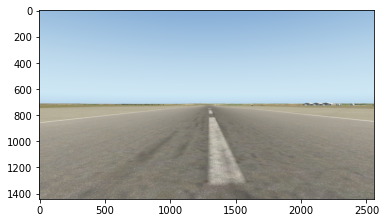

In [26]:
plt.imshow(ss)

## Image Processing

The image we took of the runway contains a lot extra information in it that we dont need for our task of locating ourselved on the runway. We want to make the job of determining the state of the aircraft from the images as easy as possible for our neural network, so let's manually remove some of this extra information.

First, while your screen has a nice high resolution for to enhance your viewing experience, we really don't need that clear of a picture in order to determine where we are on the runway, so let's resize the image to make it smaller. To do this, we can use the `cv2.resize` function. This function takes in the image to resize as its first argument, and the desired size as a tuple in the second argument. We want to make our image (360, 200) pixels in size. Implement the resizing below!

In [27]:
# STUDENT CODE START
img_resized = cv2.resize(ss, (360, 200)) # replace this with your call to cv2.resize
# STUDENT CODE END

Let's check out our new image:

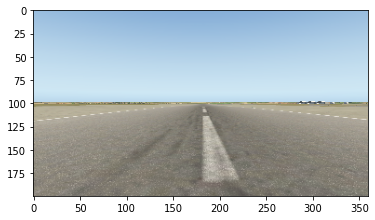

In [28]:
plt.imshow(img_resized)

Another part of the image that isn't very useful for determining where we are on the runway is the sky. The sky doesn't change much depending on where we are, so let's just crop it out! To do this, we can simply remove those values from the array. The first dimension of the array corresponds to rows of pixels going from top to bottom. To get rid of the sky, we want to create a new array that does not contain the first few rows. Create a new array that gets rid of the first 100 rows of pixels below:

In [29]:
# STUDENT CODE START
img_cropped = img_resized[100:, :, :] # replace this with your array indexing
# STUDENT CODE END

Let's check out our cropped image:

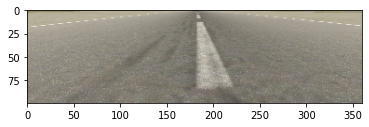

In [30]:
plt.imshow(img_cropped)

Our image is getting simpler! Let's keep going. Another thing we can get rid of is the color. We can probably determine where we are on the runway just as well from a grayscale image as we could from a color image. Remember those three channels for red, green, and blue? That's three values for each pixel. If we combine them into one brightness value by converting to grayscale, we can decrease the amount of information to one value per pixel!

Run the following to convert to grayscale and visualize the new image:

In [32]:
img_grayscale = np.array(Image.fromarray(img_cropped).convert('L')) / 255.0

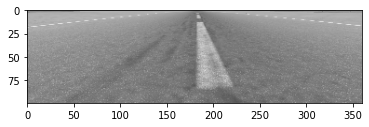

In [33]:
plt.imshow(img_grayscale, cmap = 'gray', clim=(0,1))

There are a couple things to notice from the cells above. 
- In the first cell, we divided all of our pixel values by 255. Remember how all the intensity values range between 0 and 255? We can make them all range between 0 and 1 by dividing by 255. These smaller values are easier to handle. We could easily convert back to the original values at any point by multiplying each pixel value by 255.
- In the second cell, we use `plt.imshow` again, but for grayscale images we need a few additional arguments to the function. The `cmap = 'gray'` part tells the function to show a grayscale image and the `clim`=(0,1) part tells it that the values range from 0 to 1.

Think this is as simple as it can get? Actually, we can make it even simpler! Currently, our image still has 3,600 pixels. That is still a lot of information for our neural network to take in. In this next step, we will cut the number of pixels down all the way to 128 total pixels!

This step is called "downsampling". To do this, we divide our image into a bunch of smaller regions and then summarize each region with one pixel value in the new downsampled image. We do this by taking the mean of the 16 brightest pixels in each region. Why do you think we might only want to average the brightest pixels? Discuss this with your group.

In [36]:
stride = 16
numPix = 16
width = 256//stride
height = 128//stride

# Downsample image
# Split image into stride x stride boxes, average numPix brightest pixels in that box
# As a result, img_ds has one value for every box
img_grayscale_resize = cv2.resize(img_grayscale, (256, 128))
img_ds = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        img_ds[i, j] = np.mean(np.sort(
            img_grayscale_resize[stride*i:stride*(i+1), stride*j:stride*(j+1)].reshape(-1))[-numPix:])

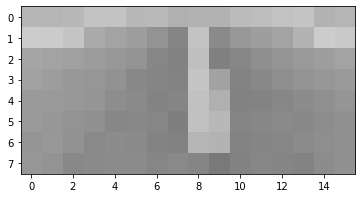

In [37]:
plt.imshow(img_ds, cmap = 'gray', clim=(0,1))

Looks pretty blurry right? Turns out that even though this is blurry, we can still pick out where the centerline and edge lines of the runway are, and this should actually be enough information for the neural network to work! In fact, this downsampling highlighted the centerlines, which may make it even easier for the neural network to figure out where we are on the runway. 

At this point, we are almost done! We just need to do one last thing. The following cell ensure that the mean of the pixe values in the image is 0.5 and that values range between 0 and 1. Why do you think we would want to do this? Discuss with your group

In [39]:
# Ensure that the mean of the image is 0.5 and that values range between 0 and 1
img_ds -= img_ds.mean()
img_ds += 0.5
img_ds[img_ds > 1] = 1
img_ds[img_ds < 0] = 0

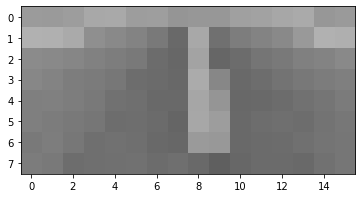

In [40]:
plt.imshow(img_ds, cmap = 'gray', clim=(0,1))

We did it! We now have a small image that contains only the information we should need to figure out where we are on the runway. In order to easily obtain a screenshot and processed image, let's combine everything we just did into a single function called `getCurrentImage` that will return the raw and processed image based on what is currently on the screen. Copy and paste all the code from above to fill in the function below:

In [6]:
def getCurrentImage(screenShot):
    """ Returns both the current image (direct screenshot) and 
        processed 128-pixel image
        Args:
            screenShot: mss screenshot object
    """
    # STUDENT CODE START
    # Get the screenshot
    ss = cv2.cvtColor(np.array(screenShot.grab(screenShot.monitors[0])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
    # Resize to 360x200
    img_resized = cv2.resize(ss, (360, 200))
    # Crop out the sky
    img_cropped = img_resized[100:, :, :]
    # Convert to grayscale
    img_grayscale = np.array(Image.fromarray(img_cropped).convert('L')) / 255.0
    # Downsample
    stride = 16
    numPix = 16
    width = 256//stride
    height = 128//stride

    # Downsample image
    # Split image into stride x stride boxes, average numPix brightest pixels in that box
    # As a result, img_ds has one value for every box
    img_grayscale_resize = cv2.resize(img_grayscale, (256, 128))
    img_ds = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            img_ds[i, j] = np.mean(np.sort(
                img_grayscale_resize[stride*i:stride*(i+1), stride*j:stride*(j+1)].reshape(-1))[-numPix:])
    # Bias to have mean of 0.5
    # Ensure that the mean of the image is 0.5 and that values range between 0 and 1
    img_ds -= img_ds.mean()
    img_ds += 0.5
    img_ds[img_ds > 1] = 1
    img_ds[img_ds < 0] = 0
    # Return the original screenshot and processed image
    return ss, img_ds
    # STUDENT CODE END

Test your processing function below. Make sure to get the Jupyter notebook out of the way for the screenshot to be taken. You will have 5 seconds again. 

In [44]:
time.sleep(5)
ss, img_ds = getCurrentImage(screenShot)

Let's plot the results for our example image:

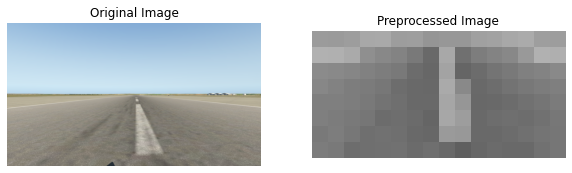

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(ss)
ax.set_title('Original Image')
plt.axis('off')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img_ds, cmap = 'gray', clim=(0,1))
ax.set_title('Preprocessed Image')
plt.axis('off')
fig.set_figwidth(10)
fig.set_figheight(5)

Feel free to move your aircraft to other points on the runway using the `setHomeState` function (see the IntroToXPlane notebook if you need a reminder of how to use it!) to see what the images look like.

## Gathering Data

In order to train our neural network to predict the state from an image, we need to give it lots of images with their corresponding states. We call this collection of images "training data". In this case, the images are our training examples, and the states are the labels. 

We want to gather data from many locations on the runway in order to teach our neural network as much as possible. To do this, we will sample random locations on the runway (crosstrack error, downtrack position, and heading error). Let's write a function to generate some samples. 

We will use the `np.random.uniform` function to get our random samples. This function will select a random number (or set of random numbers) between two values. For example `np.random.uniform(5, 20, (1, 10))` will return a 1x10 array of random numbers between 5 and 20.

Use this to fill in the following function to generate samples for the training data:

In [7]:
def getRandomLocations(numSamples, dtpLims=(322.0, 422.0), cteLims=(-10.0, 10.0), heLims=(-20.0, 20.0)):
    """ Returns set of random locations on the runway to collect images
        for training data in an array of size 3 x numSamples where the first row
        contains the downtrack positions, the second row contains the crosstrack
        errors, and the third row contains the heading errors
        Args:
            numSamples: number of datapoints to generate
            -------------------------------
            dtpLims: range of possible downtrack positions (meters)
            cteLims: range of possible crosstrack errors (meters)
            heLims: range of possible heading errors (degrees)
    """
    # STUDENT CODE START
    # Generate numSamples random downtrack position samples (get a 1 x numSamples array)
    dtp_samples = np.random.uniform(dtpLims[0], dtpLims[1], (1, numSamples)) # Replace with your call to np.random.uniform
    # Generate numSamples random crosstrack error samples (get a 1 x numSamples array)
    cte_samples = np.random.uniform(cteLims[0], cteLims[1], (1, numSamples)) # Replace with your call to np.random.uniform
    # Generate numSamples random heading error samples (get a 1 x numSamples array)
    he_samples = np.random.uniform(heLims[0], heLims[1], (1, numSamples)) # Replace with your call to np.random.uniform
    # STUDENT CODE END
    return np.vstack((dtp_samples, cte_samples, he_samples))

We are now ready to generate our data! Our goal is to end up with two arrays: one containing our training examples and the other containing the labels. The array of training examples should contain the flattened images and have dimension 128 x numSamples. The labels array should have dimension 2 x numSamples where the first row contains the crosstrack error and the second row contains the heading errors.

Fill in the following function that will help us generate data:

In [8]:
def generateImageData(client, screenShot, numSamples):
    """ Returns arrays of training examples and labels for numSamplesPoints
        The array of training examples should contain the flattened images
        and have dimension 128 x numSamples. The labels array should have 
        dimension 2 x numSamples where the first row contains the crosstrack 
        error and the second row contains the heading errors.
        Args:
            client: XPlane Client
            screenShot: mss screenshot object
            numSamples: number of datapoints to generate
    """
    # Initialize data arrays
    X = np.zeros((128, numSamples))
    y = np.zeros((2, numSamples))

    # STUDENT CODE START
    # Get numSamples locations using the getRandomLocations function
    locations = getRandomLocations(numSamples)
    # Iterate through the locations and get data
    for i in range(numSamples):
        if i % 1000 == 0:
            print(i)
        # Move to the new location using setHomeState
        setHomeState(client, locations[1, i], locations[0, i], locations[2, i])
        # Pause to make sure simulator has time to move
        time.sleep(0.1)
        # Get the preprocessed image
        _, img = getCurrentImage(screenShot)
        # Store image in X
        # NOTE: we want to store the image in column i of X, 
        # which means we need the image to be 128 x 1. Currently,
        # the image is 8 x 16. We can make it 128 x 1 by calling
        # img.flatten()
        X[:, i] = img.flatten()
        # Store crosstrack and heading error in y
        y[0, i] = locations[1, i]
        y[1, i] = locations[2, i]
    # STUDENT CODE END

    return X, y

Let's test it out by generating dataset with 10 datapoints. Again, make sure to get the Jupyter notebook out of the way in the first 5 seconds.

In [9]:
time.sleep(5)
X, y = generateImageData(client, screenShot, 20000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [11]:
import h5py

In [13]:
with h5py.File("taxi_ai4all_data.h5", "w") as p:
  p.create_dataset("X", data = X)
  p.create_dataset("y", data = y)

Run the following cell to visualize the data you generated:

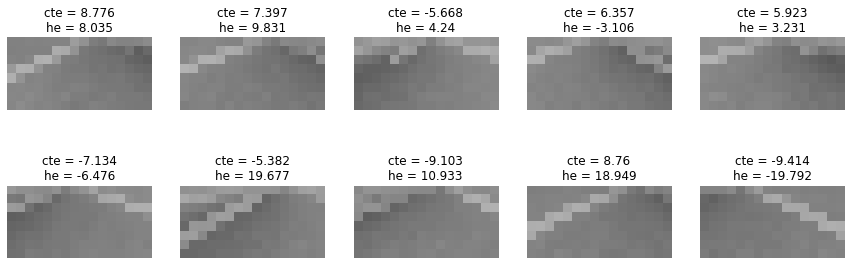

In [10]:
fig = plt.figure()

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    img = np.reshape(X[:, i], (8, 16))
    imgplot = plt.imshow(img, cmap = 'gray', clim=(0,1))
    title_string = 'cte = ' + str(round(y[0, i], 3)) + '\nhe = ' + str(round(y[1, i], 3))
    ax.set_title(title_string)
    plt.axis('off')

fig.set_figwidth(15)
fig.set_figheight(5)

We will need many more than 10 datapoints to get your neural network working. To speed things up for you, we have gone through the trouble of generating a dataset of 20,000 datapoints for you to use to train your network :)

In [93]:
client.sendDREF("sim/time/zulu_time_sec", 8 * 3600 + 8 * 3600)